In [1]:
import sys
sys.path.insert(1, r'C:\Users\Donald\PycharmProjects\monkey_nuc_segment\stardist\monkey')
from scoring_for_donald import TileSetScorer, ScoringSubroutine

In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
import json
matplotlib.rcParams["image.interpolation"] = 'nearest'
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from glob import glob
from tqdm import tqdm
from tifffile import imread
import struct
import pandas as pd
import cv2
from csbdeep.utils import Path, normalize
from glob import glob

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D

In [3]:
def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model

In [4]:
# load tile images and masks
pthHE = r'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\tiles'
pthmasks = r'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\qupath\ground_truth\masks'

HE_tiles_pths = sorted(glob(os.path.join(pthHE,'*.tif')))
mask_tiles_pths = sorted(glob(os.path.join(pthmasks,'*.tif')))

HE_tiles = list(map(imread,HE_tiles_pths))
mask_tiles = list(map(imread,mask_tiles_pths))

HE_tiles_default = [normalize(x) for x in HE_tiles]  # just divide by 255 to get into (0,1) range
mask_tiles_default = [fill_label_holes(y) for y in mask_tiles]  # fills holes in annotations if there are any

HE_tiles = [x/255 for x in HE_tiles]  # just divide by 255 to get into (0,1) range
mask_tiles = [fill_label_holes(y) for y in mask_tiles]  # fills holes in annotations if there are any

In [6]:
pth_pickle = r'\\10.99.68.178\andreex\data\Stardist\hyperparameter_testing_12_13_data\results_FINAL.pkl'
df = pd.read_pickle(pth_pickle)

In [8]:
len(df)

96

In [9]:
len(df[0])

5

In [12]:
df[0][0].head()

,Organ,TP,FP,FN,AP,Recall,Precision,F1,Tau,pth_model
0,eyes,338,23,101,0.731602,0.769932,0.936288,0.845000,0.5,monkey_12_12_2023_lr_0.0005_epochs_100_pt_10_g...
1,bone,113,13,53,0.631285,0.680723,0.896825,0.773973,0.5,monkey_12_12_2023_lr_0.0005_epochs_100_pt_10_g...
2,liver,284,26,88,0.713568,0.763441,0.916129,0.832845,0.5,monkey_12_12_2023_lr_0.0005_epochs_100_pt_10_g...
3,ears,268,52,112,0.620370,0.705263,0.837500,0.765714,0.5,monkey_12_12_2023_lr_0.0005_epochs_100_pt_10_g...
4,brain,847,88,273,0.701159,0.756250,0.905882,0.824331,0.5,monkey_12_12_2023_lr_0.0005_epochs_100_pt_10_g...


In [13]:
def mean_avg_precision(df):
    MAP = 0

    for i in range(len(df)):
        row = df.iloc[i]

        MAP += row['AP']

    MAP = MAP/len(df)

    return MAP

In [15]:
model_mAPs = []
for df_list in df:
    mAPs = []
    for df in df_list:
        if type(df) != int:
            # print(df.iloc[0]['Tau'])
            #df.head()
            mAP = mean_avg_precision(df)
            # print(mAP)
            mAPs.append(mAP)
        else:
            mAPs.append(0)
    model_mAPs.append(mAPs)

In [16]:
model_mAPs[0]

[0.6497455474443673,
 0.5766752438649796,
 0.4533550150533056,
 0.27279020411182797,
 0.04932570569300726]

In [18]:
taus = [0.5,0.6,0.7,0.8,0.9]

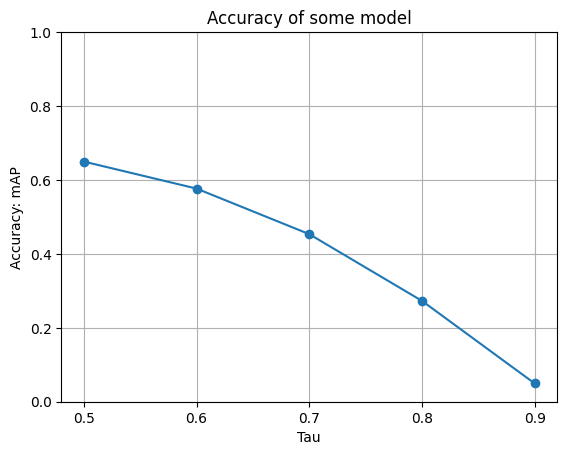

In [19]:
plt.plot(taus, model_mAPs[0], marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Tau')
plt.ylabel('Accuracy: mAP')
plt.title('Accuracy of some model')
plt.xticks(taus)
plt.ylim(0, 1)
plt.grid('on')

# Display the plot
plt.show()

In [21]:
model_mAPs

[[0.6497455474443673,
  0.5766752438649796,
  0.4533550150533056,
  0.27279020411182797,
  0.04932570569300726],
 [0.6474682934117701,
  0.5737838326820074,
  0.4524243366434354,
  0.2635759192890016,
  0.031821769237044974],
 [0.641020398339668,
  0.5642556614971083,
  0.44809664326075715,
  0.26449014004350296,
  0.03779779041544386],
 [0.64502660271505,
  0.5693088756168806,
  0.4548439048436756,
  0.2562886939117379,
  0.03808546611855219],
 [0.6468098383022293,
  0.5684510930778914,
  0.4481990923943563,
  0.2647719056227213,
  0.040105395971536666],
 [0.6393892458895107,
  0.568579430937665,
  0.44884579559536963,
  0.26246777790328985,
  0.03537693365673645],
 [0.6332431840382917,
  0.5637387482728005,
  0.44245287320964394,
  0.255027879278478,
  0.03296641127129512],
 [0.6157881276502943,
  0.5330664534455867,
  0.4163726564918866,
  0.2361593300549824,
  0.03461129225250334],
 [0.6443463297348132,
  0.5732712715815814,
  0.46089788795307346,
  0.27598753270995086,
  0.0436177

In [23]:
model_pths = r'\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models'
pths = os.listdir(model_pths)
pths = ["".join([model_pths, '\\', pth]) for pth in pths if 'monkey' in pth]

In [24]:
import numpy as np
from scipy import integrate

aucs = []
means=[]

for i, mAPs in enumerate(model_mAPs):
    print(pths[i])
    if mAPs != 0:
        area_under_curve = integrate.trapz(mAPs, taus)
        mean = np.mean(mAPs)
    else:
        area_under_curve = 0
        mean = 0
    print(f"Area under the curve: {area_under_curve}")
    aucs.append(area_under_curve)
    print(f'Mean value on curve: {mean}\n')
    means.append(mean)

\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.0005_epochs_100_pt_10_gaus_ratio_0
Area under the curve: 0.16523560895988007
Mean value on curve: 0.40037834323349764

\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.0005_epochs_100_pt_10_gaus_ratio_0.1
Area under the curve: 0.1629429119938852
Mean value on curve: 0.39381483025265196

\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.0005_epochs_100_pt_20_gaus_ratio_0
Area under the curve: 0.16162515391789242
Mean value on curve: 0.39113212671129605

\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.0005_epochs_100_pt_20_gaus_ratio_0.1
Area under the curve: 0.16219975087890953
Mean value on curve: 0.3927107086411793

\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.0005_epochs_100_pt_30_gaus_ratio_0
Area under the curve: 0.1624879708231852
Mean v

In [25]:
sorted(means)

[0.0015386789617515915,
 0.001547653278783387,
 0.0015502033062833678,
 0.0016538054107252324,
 0.0016829205985764897,
 0.00168981882432768,
 0.0017012681068675315,
 0.0017122761708359576,
 0.0018074718025485245,
 0.002029845177755818,
 0.0021449442925930385,
 0.0032800103692477885,
 0.2321613970680625,
 0.29796047772600126,
 0.31165802880325455,
 0.33146437310096294,
 0.33430215354537035,
 0.34665080363696615,
 0.3481952587147968,
 0.3483352265468798,
 0.34939487622273807,
 0.349666257073754,
 0.3517918896643439,
 0.3519339478060245,
 0.35562120850281914,
 0.35763447667253107,
 0.36202266341478484,
 0.3627048275459962,
 0.36306177572956083,
 0.36346410693074016,
 0.3660491963340501,
 0.3671995719790507,
 0.3673021968530255,
 0.36762372509013974,
 0.37060157104010744,
 0.3710433414800019,
 0.37185770739035806,
 0.3739806763624898,
 0.3741992211931532,
 0.3744081732052048,
 0.3746285364078211,
 0.3754773765946319,
 0.3761568960263737,
 0.3764615022170199,
 0.3776179794648312,
 0.3792451

In [26]:
sorted(aucs)

[0.00038466974043789776,
 0.00038691331969584663,
 0.00038755082657084184,
 0.00041345135268130805,
 0.0004207301496441223,
 0.0004224547060819199,
 0.00042531702671688276,
 0.0004280690427089893,
 0.0005074612944389544,
 0.0005434258432602742,
 0.0006427699230131878,
 0.0009869621779672907,
 0.090121851749518,
 0.12153421827976148,
 0.12642574875752427,
 0.13554171040353086,
 0.1377363042227952,
 0.14181665035531305,
 0.14292964637422298,
 0.14315079298925096,
 0.14345346981276985,
 0.1435446106184805,
 0.14450037028717935,
 0.14479696225295105,
 0.1462869192131141,
 0.1473188355909102,
 0.14904452207624444,
 0.14984113266576143,
 0.15004437010855118,
 0.15007159831191333,
 0.15065672473494277,
 0.15107981499438547,
 0.15113643981643302,
 0.15203715409074217,
 0.1520954375965255,
 0.15269031685072593,
 0.1534802735161441,
 0.15383176748518088,
 0.1542418366137235,
 0.15447730975474888,
 0.15452122875024515,
 0.15477342518362652,
 0.1550710341864926,
 0.15552625768122463,
 0.1558739725

In [27]:
ind = np.argmax(means)
pths[ind]

'\\\\10.99.68.178\\andreex\\data\\Stardist\\12_12_hyperparameter_models\\monkey_12_12_2023_lr_0.001_epochs_400_pt_10_gaus_ratio_0'

In [ ]:
# check old model to see score

In [37]:
model_mAPs[50]

[0.6361457820996258,
 0.5611798127696268,
 0.43339340247698616,
 0.2550536636928585,
 0.03814889452172772]

In [31]:
model_mAPs[ind]

[0.6622550218559431,
 0.5911165634917219,
 0.4679371945161191,
 0.2818643935075125,
 0.040305406398221645]

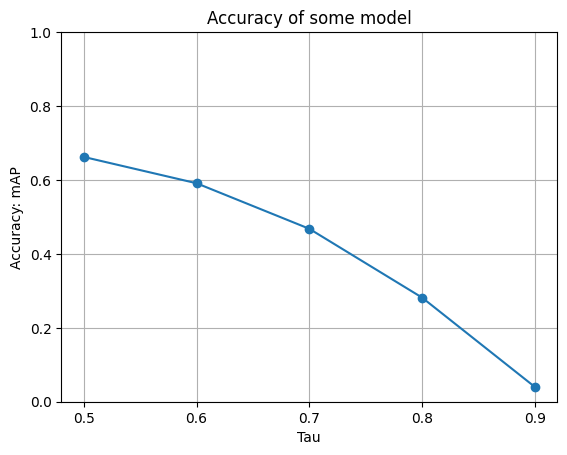

In [28]:
plt.plot(taus, model_mAPs[ind], marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Tau')
plt.ylabel('Accuracy: mAP')
plt.title('Accuracy of some model')
plt.xticks(taus)
plt.ylim(0, 1)
plt.grid('on')

# Display the plot
plt.show()